*updated 21 Jan 2026, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---
# 7. Recurrent Neural Networks (RNNs)

Here we switch gears to deal with ***sequences*** of data. Examples of these are:

* Text data (e.g. genomic data, novels)
* Time-series data
* Acoustic data (e.g. music)
* Speech data

The main thing is you think the future states depends on the past, and what you want to do is make predictions based on previous data, i.e. there is some ***memory*** effect. One class of neural networks that builds in some memory effect is the ***Recurrent Neural Network*** (RNN), and we are going to do this through `keras`.

> ## Key Objective(s)
> 1. Introduce recurrent neural networks and demonstrate its use in time-series predictions.
> 2. Experiment with the GRU and LSTM architectures.
> 3. A quick look at ConvLSTMs.

Load some basic things as usual.

In [1]:
# load some packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# PyTorch (not using it very much if at all here though; just load the base one)
import torch
from torch.utils.data import Dataset, DataLoader

# keras related
import os
os.environ["KERAS_BACKEND"] = "torch"  # use PyTorch as backend
import keras
import keras.layers as layers
keras.backend.clear_session() # force a clean keras session (clears models etc.)

from tqdm.keras import TqdmCallback

# check for GPUs availability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


---
## a) Basics of RNNs

One example of the architecture is below; this is not the only one, but illustrates the some key components of RNNs.

<img src="https://i.imgur.com/fozD28d.png" width="600" alt='rnn'>

> NOTE: You might see it depicted differently in the other online materials, usually described as a feedforward network that gets used repeatedly. The above one makes more sense to me personally because the hidden state makes it a bit more subtle than that "feedforward" description.

The main thing that is different to neural nets introduced so far is the presence of a ***hidden state*** alongside the input data; I am going to refer to the tuple `(input_data, hidden_state)` as the ***input***. Here is that the predictions depends on the hidden state itself, and how `input_data` gets updated depends on the `hidden_state`. For example,  if `f(input_data) = (input_data + hidden_state, input_data)`, then `f(1) = 1` the first time but `f(1) = 2` the second time if `hidden_state = 0` to begin with, since the `hidden_state` has updated when `f` is called the second time.

The ordering of operation above diagram is as follows:

1. Choose input `(input_data, hidden_state)`; `input_data` is from your training data, `hidden_state` is normally initialised to zeroes.
2. `input_data` gets transformed in some way by a neural network block `A` (say).
3. `hidden_state` gets transformed in some way by a different neural network block `B` (say).
4. The returned array of numbers from `A` and `B` are summed and then activated (usually a `tanh` function, although `ReLU` is also used) and returns a `new_hidden_state` (which is an array of numbers).
5. This `new_hidden_state` is transformed by another neural network block `C` and activated accordingly to give an `new_input`.
6. Take the output (`new_input`, `new_hidden_state`) and pass through the RNN again.
7. That generates a sequence of data, from which you can evaluate the loss again the provided training data.
8. Do back-propagation relative to that loss, update the parameters in `A`, `B` and `C`, and iterate.

In this case there is some freedom in how you specify the size of the `hidden_state`, the neural network blocks (`A`, `B`, `C` can in principle all be different as long as their transformation rules are defined consistently), more things can be put in also (e.g. memory gates relating to ***LSTM*** and ***GRU*** architectures), and the neural networks can include convolutions also (e.g. ***ConvLSTM***). For this particular course we are only going to deal with the simple RNNs.

### 1) Time-series data from Lotka-Volterra (or Predator-Prey) model

For the demonstration here we are going to generate some time-series data first. For this I am going to numerically solve the [Lotka-Volterra](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) or ***predator-prey*** model, given by
\begin{equation*}
    \frac{\mathrm{d}x}{\mathrm{d}t} = a x - b x y, \qquad \frac{\mathrm{d}x}{\mathrm{d}t} = -c y - d x y,
\end{equation*}
where ($x$, $y$) = (prey, predators) populations (in some units), and $(a,b,c,d)$ are parameters governing birth, death from predation, death and birth from predation (in some consistent units with how $x$, $y$ and $t$ are defined). I am going to leverage the `scipy` inbuilt functionalities to generate a sequence of data resulting from the model.

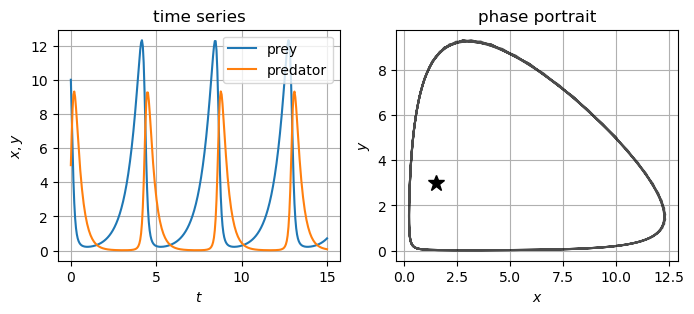

In [2]:
# generate some data from Lotka-Volterra

from scipy.integrate import solve_ivp

def LotkaVolterra(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

t = np.linspace(0, 15, 300)
a, b, c, d = 1.5, 1, 3, 1
sol = solve_ivp(LotkaVolterra, [0, 15], [10, 5], args=(a, b, c, d), t_eval=t,
               rtol=1e-6, atol=1e-9)
x, y = sol.y

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(t, x, label=r"prey")
ax.plot(t, y, label="predator")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x, y$")
ax.set_title(r"time series")
ax.legend()
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.plot(x, y, 'k-', alpha=0.7)
ax.plot(a/b, c/d, 'k*', markersize=12)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title(r"phase portrait")
ax.grid()

Lotka-Volterra is known to have cyclic/periodic behaviour, as seen by the time-series but more clearly from the ***phase portrait*** where I plot $x(t)$ against $y(t)$ for all values of $t$. I've also marked on the non-trivial ***equilibrium point*** of this system as a star.

First I want to process the data (which is nested in `sol.y`) to be fed into a RNN. I am going to be lazy and not have any testing data (but see the tests I will do later). In the simplest case I would do a one-step prediction, i.e. the training input data is `[x[i], y[i]]` of `i=0, 1, ... N-1`, and the training output data is `[x[i+1], y[i+1]]` for the same `i` values. In this case the RNN is only ever triggered once; you could argue the it's not really an RNN, but note that there is the hidden state block floating around affecting the outcomes, so it is certainly not the usual neural network either.

The below subroutine is defined to chop up the sequences accordingly, and it's done so that it could in principle produce arbitrary input sequence lengths, which I will use later.

> NOTE: I could introduce randomness by shuffling which samples of sequences I select (e.g. with a `DataLoader`). I could introduce test and validation data by not passing all the data to the network during the training; this I don't do but is easy to put in with `sklearn` and `keras`.

In [3]:
# chop it up into sequences (assumes data sequence is of dim larger than 1)
def create_sequences(data, seq_length=1):
    x_dum, y_dum = [], []
    n_sample = data.shape[0] - seq_length
    for i in range(n_sample):
        x_dum.append(data[i:i+seq_length, :])  # sequence used to predict end point
        y_dum.append(data[i+seq_length, :])    # end point
    return np.asarray(x_dum), np.asarray(y_dum)

X, Y = create_sequences(sol.y.T, seq_length=1)  # need transpose of "sol.y" to get right shape

print(f"input shape is (batch_size, seq, dim) = {X.shape}")
print(f"input shape is (batch_size, dim) = {Y.shape}")

input shape is (batch_size, seq, dim) = (299, 1, 2)
input shape is (batch_size, dim) = (299, 2)


Notice in this case the shape of the inputs has an extra dimension that encodes the input sequence length (in this case it's one).

> NOTE: The resulting singleton dimensions may need to be ***squeezed*** out later.

For the RNN architecture, you could try and build it manually, but you could also just use the inbuilt `PyTorch` or `keras` functionality; I am going to use the latter. 

Below is my attempt at wrapping up a RNN. The variable namings I defined here mirrors the namings that are expected in `nn.RNN` in `PyTorch`:

* `input_size`: Dimensionality of input. For the Lotka-Volterra this would be `2`, because ($x,y$).
* `output_size`: Dimensionality of output. For the Lotka-Volterra this would also be `2`, because it is predicting the next state in time.
* `seq_length`: This is not in `PyTorch`, and is the dimension of sequence length, i.e. number of time-steps you throw in.
* `hidden_size`: How big you want the memory block to be. Arguably bigger is better, but this increases your neural network blocks `B` and `C` in the schematic above, which may promote over-fitting and slow down your training steps etc.
* `num_layers`: How many of these Elman RNNs you want to stack together. If you have `num_layers=2`, then you would have neural network blocks `(A1, B1, C1)` and `(A2, B2, C2)` each with their own associated weights and/or biases that are can be trained.

> NOTE: In the below `rnn_cells` definition below you need to use the `SimpleRNNCell` variant. There is a `SimpleRNN` that you can call, but that will lead to crashes (because of dimensionality mismatch). The `Cell` part is important, and the `RNN` part considers the stacked cells (even if it is a stack of 1) as one "layer".
>
> I could have used `Sequential` below but I didn't.

In [4]:
# keras wrap of a simple RNN (possibly stacked) with a linear layer output

def simple_rnn(input_size, output_size, seq_length=1, hidden_size=1, num_layers=1):

    # need to use the "Cell" variant to loop up
    rnn_cells = [layers.SimpleRNNCell(hidden_size) for _ in range(num_layers)]

    inputs = keras.Input(shape=(seq_length, input_size))
    x = layers.RNN(rnn_cells)(inputs)  # this is one block
    outputs = layers.Dense(output_size)(x)
    model = keras.Model(inputs, outputs, name="simple RNN")

    return model

dummy = simple_rnn(2, 2, seq_length=1, hidden_size=60, num_layers=1)
dummy.summary()

Model: "simple RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, 60)             │         3,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,902 (15.24 KB)

 Trainable params: 3,902 (15.24 KB)

 Non-trainable params: 0 (0.00 B)

I am going to be keeping it simple and make things reasonably small. I want to do some shuffling, so I am going to define a simple `Dataset` object and use a `DataLoader` also.

> NOTE: There are various things you can switch on with the RNN cells that can be done above. You could output the `hidden_state`, but then I didn't because I don't really need it.

> NOTE: Not going to standarise the data here. You may want to at least min/max the data to `[-1, 1]` or similar. In this case I would argue you probably want to normalise it by non-dimensionalising the data with respect to the birth or decay rate `a` or `b`.

In  data shape = (299, 1, 2)
Out data shape = (299, 2)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

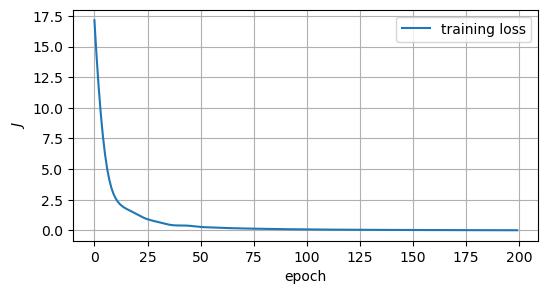

In [5]:
class MyDataset(Dataset):

    def __init__(self, in_tensor, out_tensor):
        self.inp = in_tensor
        self.out = out_tensor

    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        return self.inp[idx], self.out[idx]

# specify the seeds
torch.manual_seed(1234)
keras.utils.set_random_seed(4321)

# use all the data for training (don't have to do this)
X_train, Y_train = X, Y
train_dataset = MyDataset(X, Y)
print(f"In  data shape = {train_dataset.inp.shape}")
print(f"Out data shape = {train_dataset.out.shape}")
n_sample = train_dataset.__len__()

train_dataloader = DataLoader(train_dataset, 
                              batch_size=n_sample // 1, 
                              shuffle=True)

# compile
RNN = simple_rnn(2, 2, seq_length=1, hidden_size=60, num_layers=1)

learning_rate = 0.01
RNN.compile(loss=keras.losses.MeanSquaredError(),
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            )

train_log = RNN.fit(train_dataloader, 
                    epochs=200,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)],
                   )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

### "Easy" testing

I am first going to do the easy case first of throwing in the input and seeing what the output is. The given data is going to be markers, and the predictions are lines. According to the loss curve above it should be pretty good.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


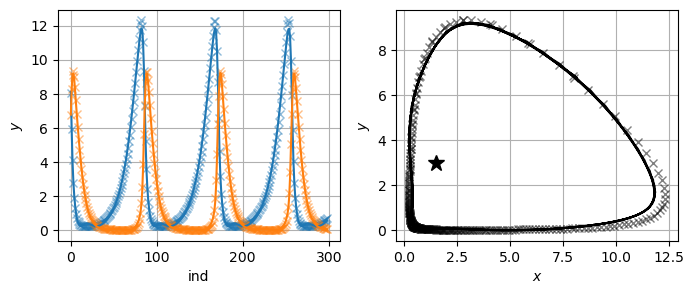

In [6]:
# compare results
predictions_train = RNN.predict(X_train)

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(Y_train[:, 0], 'C0x', alpha=0.5)
ax.plot(Y_train[:, 1], 'C1x', alpha=0.5)
ax.plot(predictions_train[:, 0], 'C0-')
ax.plot(predictions_train[:, 1], 'C1-')
ax.set_xlabel(r"ind")
ax.set_ylabel(r"$y$")
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.plot(Y_train[:, 0], Y_train[:, 1], 'kx', alpha=0.5)
ax.plot(predictions_train[:, 0], predictions_train[:, 1], "k-")
ax.plot(a/b, c/d, 'k*', markersize=12)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.grid();

It looks pretty good, although you can see some issues with the phase portraits, which is indicating there are issues with the extreme values (the peaks).

> NOTE: Could quanitfy this properly with computing the RMS errors over time for example.

### "Harder" testing

Here would be I provide the initial condition, and then keep hitting the predicted output with the RNN. This is a more relevant but harder test because ultimately we might want to use the RNN to make predictions, but the errors with each prediction may accumulate with every pass of the RNN, which may or may not cancel out.

> NOTE: For this nonlinear oscillator we might suspect it would be ok given the limit cycle behaviour, but who knows...

In [7]:
# initialise a who chunk of zeros, dump in the prediction, and use as the next input
predictions_from_init = np.zeros(Y_train.shape)
X_in = X_train[0, :, :]
for i in range(Y_train.shape[0]):
    Y_pred = RNN.predict(X_in.reshape(-1, 1, 2), verbose=0)  # suppress outputs
    predictions_from_init[i, :] = Y_pred.squeeze() # squeeze that dummy singleton dim
    X_in = Y_pred # use previous prediction as new input

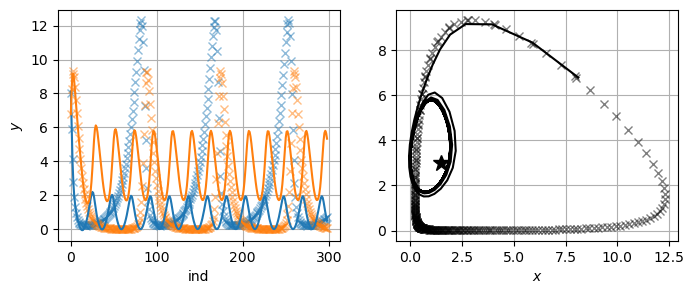

In [8]:
# time series and phase portrait

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(Y_train[:, 0], 'C0x', alpha=0.5)
ax.plot(Y_train[:, 1], 'C1x', alpha=0.5)
ax.plot(predictions_from_init[:, 0], 'C0-')
ax.plot(predictions_from_init[:, 1], 'C1-')
ax.set_xlabel(r"ind")
ax.set_ylabel(r"$y$")
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.plot(Y_train[:, 0], Y_train[:, 1], 'kx', alpha=0.5)
ax.plot(predictions_from_init[:, 0], predictions_from_init[:, 1], 'k-')
ax.plot(a/b, c/d, 'k*', markersize=12)
ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$y$")
ax.grid();

So this one does not do very well after a while, which is perhaps not entirely surprising given we only ask it to do one-step predictions, and the errors start adding up...

### "Hard" test again but increasing the input sequence length

I am going to re-train the model with a longer sequence and then do the "hard" test on it, to see if providing more previous time snapshots will help with the recovering the cyclic behaviour at least.

> NOTE: With increased sequence length I will have a smaller amount of samples. For this case I could always run the model for longer to generate more data, but I am not going to do that for simplicity.

input shape is (batch_size, seq, dim) = (290, 10, 2)
input shape is (batch_size, dim) = (290, 2)
In  data shape = (290, 10, 2)
Out data shape = (290, 2)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

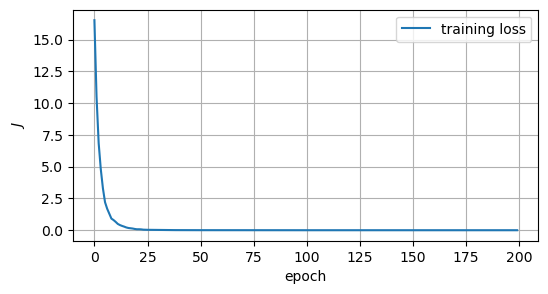

In [9]:
# use longer sequences of data
seq_length = 10
X, Y = create_sequences(sol.y.T, seq_length=seq_length)

print(f"input shape is (batch_size, seq, dim) = {X.shape}")
print(f"input shape is (batch_size, dim) = {Y.shape}")

# specify the seeds
torch.manual_seed(1234)
keras.utils.set_random_seed(4321)

# use all the data for training (don't have to do this)
X_train, Y_train = X, Y
train_dataset = MyDataset(X, Y)
print(f"In  data shape = {train_dataset.inp.shape}")
print(f"Out data shape = {train_dataset.out.shape}")
n_sample = train_dataset.__len__()

train_dataloader = DataLoader(train_dataset, 
                              batch_size=n_sample // 1, 
                              shuffle=True)

# compile
RNN = simple_rnn(2, 2, seq_length=seq_length, hidden_size=60, num_layers=1)

learning_rate = 0.01
RNN.compile(loss=keras.losses.MeanSquaredError(),
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            )

train_log = RNN.fit(train_dataloader, 
                    epochs=200,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)],
                   )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
# ax.plot(train_log.epoch, train_log.history["val_loss"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

In [10]:
# initialise a who chunk of zeros, dump in the prediction, and use as the next input
predictions_from_init = np.zeros(Y_train.shape)
X_in = X_train[0, :, :]
for i in range(Y_train.shape[0]):
    Y_pred = RNN.predict(X_in.reshape(-1, seq_length, 2), verbose=0)  # suppress outputs
    predictions_from_init[i, :] = Y_pred.squeeze() # squeeze that dummy singleton dim

    # update the input sequence
    X_dum = np.zeros(X_in.shape)
    X_dum[0:-1, :] = X_in[1:, :]
    X_dum[-1, :] = Y_pred
    X_in = X_dum

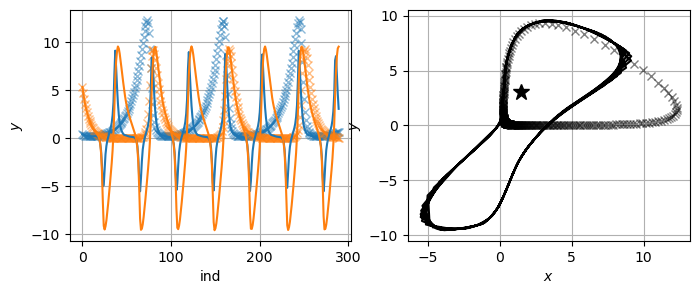

In [11]:
# time series and phase portrait

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(Y_train[:, 0], 'C0x', alpha=0.5)
ax.plot(Y_train[:, 1], 'C1x', alpha=0.5)
ax.plot(predictions_from_init[:, 0], 'C0-')
ax.plot(predictions_from_init[:, 1], 'C1-')
ax.set_xlabel(r"ind")
ax.set_ylabel(r"$y$")
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.plot(Y_train[:, 0], Y_train[:, 1], 'kx', alpha=0.5)
ax.plot(predictions_from_init[:, 0], predictions_from_init[:, 1], 'k-')
ax.plot(a/b, c/d, 'k*', markersize=12)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.grid();

Here we see that in this case a longer sequence is doing one of the populations better, although its repeating too frequently. Saying that, the populations are actually going extinct then "resurrecting", so there are obvious funny things going on...

Anyway, the point is that there is no guarantee ML models satisfy the underlying model behaviour just from data. How you force the resulting model to satisfy constraints is a different type of beast; one method is using something like PINNs, which we will encounter in a later session.

> <span style="color:red">Q.</span> Play around with the system parameters ($a,b,c,d$) and/or initial conditions to see how the time-series changes (e.g. whether there are regime shifts), and see how that may or may not affect the RNN performance.
>
> <span style="color:red">Q.</span> Play around with the sequence length you provide and see what happens.
> 
> <span style="color:red">Q.</span> Introduce train-test-validate accordingly.
>
> <span style="color:red">Q.</span> Suppose you train an RNN on a time-series trained on a specific choice of ($a,b,c,d$). How does it perform if you deploy the same RNN but on a time-series associated with a different choice ($a,b,c,d$)? Does it depend on the exact regime (cf. above question)?
> 
> <span style="color:red">Q.</span> Consider adding noise to the data and then do the training.
>
> <span style="color:red">Q.</span> Consider training a neural network to denoise the data and then do the RNN training. You could do the denoising of the predictions on the fly, or before you pass the data into the training.

---
## b) LSTMs and GRUs

These stand for ***[Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory)*** and ***[Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit)***, and are popular variations of the RNN architecture. Both of these introduce extra ***gates*** in the neural network architecture to control information flow; the GRUs could be seen as a slimmed down version of LSTMs, so mostly going to deal with LSTMs here.

One issue that happens with training of neural nets with many layers and also RNNs with long sequences is the ***exploding*** or the ***vanishing gradient***. To show what is happening, suppose we consider represent the neural net as
\begin{equation*}
    x_t = N(x_{t-1}, \theta),
\end{equation*}
where $N$ is the mapping, $x_t$ is the input at time $t$, and $\theta$ the model parameters. When we take one gradient, we get by chain rule
\begin{equation*}
    \mathrm{d}x_t = \nabla_\theta N(x_{t-1}, \theta)\; \mathrm{d}\theta + \nabla_x N(x_{t-1}, \theta)\; \mathrm{d}x_{t-1}.
\end{equation*}
Then notice that
\begin{equation*}
    \mathrm{d}x_{t-1} = \nabla_\theta N(x_{t-2}, \theta)\; \mathrm{d}\theta + \nabla_x N(x_{t-2}, \theta)\; \mathrm{d}x_{t-2}.
\end{equation*}
Collecting in $\mathrm{d}\theta$ we have
\begin{equation*}
    [\nabla_\theta N(x_{t-1}, \theta) + \nabla_x N(x_{t-1}, \theta) \nabla_\theta N(x_{t-2}, \theta)]\; \mathrm{d}\theta,
\end{equation*}
and convince yourself as you take have longer sequences (or more neural network layers) then you are going to have more and more terms being multiplied by each other. These magnitude of these terms relate to the properties of $N$: 

* If they tend to take values larger than 1, then the product will increase exponentially, leading to an exploding gradient.
* If they tend to take values smaller than 1, then the product will decrease exponentially, leading to a vanishingly small gradient.

The former should be quite easy to spot because the model training would just fail. The latter implies the updates become increasingly small/limited and the model starts "stalling". For RNNs, this means the information further away from present time is only minimally contributing to updates, and is not being "learnt" in some sense. This is not an entirely desirable property and we would like to do something about it.

> <span style="color:red">Q.</span> Try this for yourself with the above data by putting in long sequences and/or making the RNN quite deep. You may need to make the time window of the above example longer.

LSTMs (original paper [here](https://www.bioinf.jku.at/publications/older/2604.pdf)) introduces **input**, **output**, **forget gates**, each with their own weights, RNN parts and biases, with appropriate activation functions (normally sigmoids). The main thing to notice these "gates" outputs things from 0 to 1: 0 shuts things off, while 1 turns things on completely. These form the components of the LSTM memory block.

* Input gates decide what info is stored over time
* Output gates decide what info is outputted
* Forget gates (I think I would describe them as activation/deactivation gates) control what information is used; think of these are filters for things with low information content.

For an example of why this might work, consider the following sentence:

> "Julian, noted for his relentless questioning style, is not a welcome guest at the post-grad seminars."

Observe that
* `Julian` implies `his` but not really the things after, so the `Julian` piece of information could be discarded after a certain point.
* `relentless questioning` wants to be kept until `not a welcome quest` probably.
* Probably don't need `Julian` once we get to `not a welcome guest`.

Discarding information allows you to have shorter chains (which is good), and is the ***short-term*** part. The whole memory block being choosy about which parts to remember/forget (so to me it's not really "forget", but "deactivate") enables the short-term memory to be maintained ***long*** term, hence LSTM.

At a very coarse level, GRUs basically don't have the output gates. 

Going to demonstrate the above example but only with LSTM. It's basically as simple as a swap from `RNNCell` to `LSTMCell`.

In [12]:
# same game but for only for LSTMCell (GRUCell is done basically the same)

def simple_lstm(input_size, output_size, seq_length=1, hidden_size=1, num_layers=1):

    # need to use the "Cell" variant to loop up
    lstm_cells = [layers.LSTMCell(hidden_size) for _ in range(num_layers)]

    inputs = keras.Input(shape=(seq_length, input_size))
    x = layers.RNN(lstm_cells)(inputs)  # this is one block
    outputs = layers.Dense(output_size)(x)
    model = keras.Model(inputs, outputs, name="simple LSTM")

    return model

dummy = simple_lstm(2, 2, seq_length=1, hidden_size=60, num_layers=1)
dummy.summary()

Model: "simple LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_3 (RNN)                     │ (None, 60)             │        15,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,242 (59.54 KB)

 Trainable params: 15,242 (59.54 KB)

 Non-trainable params: 0 (0.00 B)

Notice the basic LSTM has more trainable parameters than the single layer simple RNN (by about a factor of four). We train it as usual but only using the data from the previous step; this is slightly defeating the point of an LSTM block (because the sequence is short), but lets see what we get.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

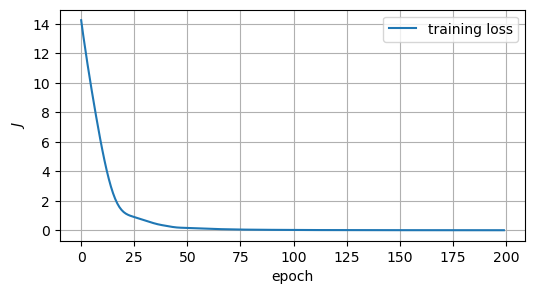

In [13]:
# use longer sequences of data
seq_length = 1
X, Y = create_sequences(sol.y.T, seq_length=seq_length)

# specify the seeds
torch.manual_seed(1234)
keras.utils.set_random_seed(4321)

# use all the data for training (don't have to do this)
X_train, Y_train = X, Y
train_dataset = MyDataset(X, Y)
n_sample = train_dataset.__len__()

train_dataloader = DataLoader(train_dataset, 
                              batch_size=n_sample // 1, 
                              shuffle=True)

# compile
LSTM = simple_lstm(2, 2, seq_length=seq_length, hidden_size=60, num_layers=1)

learning_rate = 0.01
LSTM.compile(loss=keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
             )

train_log = LSTM.fit(train_dataloader, 
                     epochs=200,
                     verbose=0,
                     callbacks=[TqdmCallback(verbose=1)],
                    )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
# ax.plot(train_log.epoch, train_log.history["val_loss"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

We are going to subject the model to the hard test of using it's own predictions to predict the later steps.

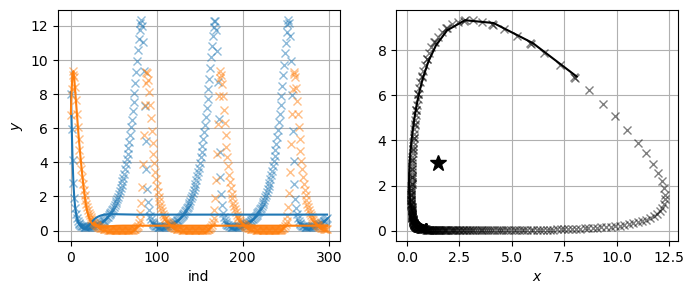

In [14]:
# initialise a who chunk of zeros, dump in the prediction, and use as the next input
predictions_from_init = np.zeros(Y_train.shape)
X_in = X_train[0, :, :]
for i in range(Y_train.shape[0]):
    Y_pred = LSTM.predict(X_in.reshape(-1, 1, 2), verbose=0)  # suppress outputs
    predictions_from_init[i, :] = Y_pred.squeeze() # squeeze that dummy singleton dim
    X_in = Y_pred # use previous prediction as new input

# time series and phase portrait

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(Y_train[:, 0], 'C0x', alpha=0.5)
ax.plot(Y_train[:, 1], 'C1x', alpha=0.5)
ax.plot(predictions_from_init[:, 0], 'C0-')
ax.plot(predictions_from_init[:, 1], 'C1-')
ax.set_xlabel(r"ind")
ax.set_ylabel(r"$y$")
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.plot(Y_train[:, 0], Y_train[:, 1], 'kx', alpha=0.5)
ax.plot(predictions_from_init[:, 0], predictions_from_init[:, 1], 'k-')
ax.plot(a/b, c/d, 'k*', markersize=12)
ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$y$")
ax.grid();

It's pretty good at the beginning but then it ends up "stalling", but at least it's not predicting resurrections...

Below training is going to use a longer sequence to do the same thing.

> NOTE: I find the training to be noticeably slower than the simple RNN. This is not surprising given there are more trainable parameters.
>
> Below uses `seq_length=10` as a default mostly for comparison with above. I find that `seq_length=20` does pretty well, if you are willing to ignore the fact one of the population goes extinct and resurrects. See later comments at the ***ConvLSTM*** section for some other things you should try modifying.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

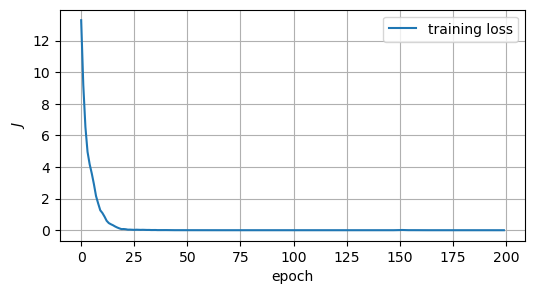

In [15]:
# use longer sequences of data
seq_length = 10
X, Y = create_sequences(sol.y.T, seq_length=seq_length)

# specify the seeds
torch.manual_seed(1234)
keras.utils.set_random_seed(4321)

# use all the data for training (don't have to do this)
X_train, Y_train = X, Y
train_dataset = MyDataset(X, Y)
n_sample = train_dataset.__len__()

train_dataloader = DataLoader(train_dataset, 
                              batch_size=n_sample // 1, 
                              shuffle=True)

# compile
LSTM = simple_lstm(2, 2, seq_length=seq_length, hidden_size=60, num_layers=1)

learning_rate = 0.01
LSTM.compile(loss=keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
             )

train_log = LSTM.fit(train_dataloader, 
                     epochs=200,
                     verbose=0,
                     callbacks=[TqdmCallback(verbose=1)],
                    )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

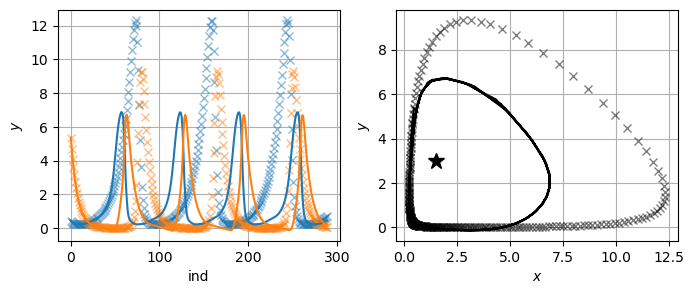

In [16]:
# initialise a who chunk of zeros, dump in the prediction, and use as the next input
predictions_from_init = np.zeros(Y_train.shape)
X_in = X_train[0, :, :]
for i in range(Y_train.shape[0]):
    Y_pred = LSTM.predict(X_in.reshape(-1, seq_length, 2), verbose=0)  # suppress outputs
    predictions_from_init[i, :] = Y_pred.squeeze() # squeeze that dummy singleton dim

    # update the input sequence
    X_dum = np.zeros(X_in.shape)
    X_dum[0:-1, :] = X_in[1:, :]
    X_dum[-1, :] = Y_pred
    X_in = X_dum

# time series and phase portrait

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(Y_train[:, 0], 'C0x', alpha=0.5)
ax.plot(Y_train[:, 1], 'C1x', alpha=0.5)
ax.plot(predictions_from_init[:, 0], 'C0-')
ax.plot(predictions_from_init[:, 1], 'C1-')
ax.set_xlabel(r"ind")
ax.set_ylabel(r"$y$")
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.plot(Y_train[:, 0], Y_train[:, 1], 'kx', alpha=0.5)
ax.plot(predictions_from_init[:, 0], predictions_from_init[:, 1], 'k-')
ax.plot(a/b, c/d, 'k*', markersize=12)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.grid();

The model is producing oscillations that are predator-prey model like, although it is not at the right amplitude or period. The phase difference is ok (the prey comes up and down before the predator). Structure seems promising, and further tuning might get it better.

> <span style="color:red">Q.</span> Play around with the sequence length you provide to it and see what happens.
>
> See also the next section on other things to vary.
>
> <span style="color:red">Q.</span> Try playing around with the architecture and other model hyper-parameters to see how you improve/degrade the model performance.
> 
> <span style="color:red">Q.</span> Do the same thing but for GRU, and see where the differences in model (e.g. number of degrees of freedom) and performance (e.g. skill, training speed etc.) occur.

---
## c) A quick look at ConvLSTMs

In the RNN blocks the default is to use the fully connected neural networks, but there is no reason you can't use convolution layers instead (e.g. sequence of images such as in a video). A common one is ***ConvLSTM*** (i.e. CNN + LSTM).

In the below case I am going to generate data from the [Korteweg-De Vries](https://en.wikipedia.org/wiki/Korteweg%E2%80%93De_Vries_equation) or the KdV equation, which is sometimes invoked as a model for tsunami waves in the (because it has special nonlinear stable solutions called ***solitons***). The resulting data is of the form $u(x,t)$, i.e. for every time-frame there is a 1d graph. I set it up so that anything that goes out form one side of the domain comes back from the other side (i.e. the domain is periodic in $x$).

In [17]:
# brute force solve the KdV equation with two solitons initial condition (sort of)
# pseudo-spectral for periodic domain
# (taken from https://scipy-cookbook.readthedocs.io/items/KdV.html)

from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff

# define the initial conditions for a single soliton, generate two of these and add them
# together
# (the two solition solution is not what is described but it's good enough...)
def kdv_exact(x, c):
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

# define the subroutine for generating \partial u / \partial t
def kdv(u, t, L):
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)
    return -6*u*ux - uxxx

# set the space and time grid
L = 50.0
N = 64
dx = L / (N - 1.0)
x = np.linspace(0, (1-1.0/N)*L, N)

# Set the time sample grid.
T = 200
t = np.linspace(0, T, 501)

# initial conditions with two solitons (caveat as above
u0 = kdv_exact(x-0.33*L, 0.75) + kdv_exact(x-0.65*L, 0.4)
sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)

For this example I set two waves going. I am going to first plot the numerical solution as a function of space $x$ at fixed $t$, and then in the second plot I am going to do a [Hovmöller](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram) that shows the solution as a function of $x$ and $t$ together (with $t$ going up). 

Either way, convince yourself what you have is that both waves are going to the right, the taller wave travels faster and catches up with the shorter wave, and eventually overtakes it. The interesting thing to observe is that when they overlap they interact somewhat (the shorter wave gets "pulled back"), but both come out effectively intact. The intactness would be obvious in the linear wave equation case (where each wave is a solution and the waves don't interact with each), but is not a trivial fact for nonlinear equations like the KdV equations where the linearity does not allow solutions to add to each other.

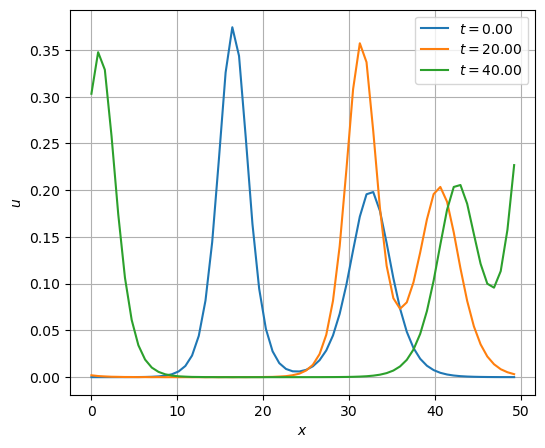

In [18]:
# snapshots in time

Nt = len(t)
inds = [0, Nt // 10, Nt // 5]

fig = plt.figure(figsize=(6, 5))
ax = plt.axes()
for i in range(len(inds)):
    ax.plot(x, sol[inds[i], :], label=f"$t = {{{t[inds[i]]:.2f}}}$")
ax.legend()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u$')
ax.grid();

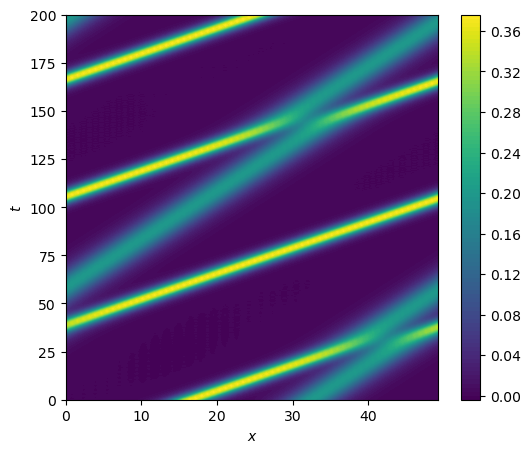

In [19]:
# Hovmoller plot (time going up)
fig = plt.figure(figsize=(6, 5))
ax = plt.axes()
cs = ax.contourf(x, t, sol, levels=101)
cax = plt.colorbar(cs)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$');

The network architecture is largely inspired from the Keras example for video frame prediction [here](https://keras.io/examples/vision/conv_lstm/). For this we are going to have inputs that is a sequence of $n$ frames, and the target is also $n$ frames shifted by one time-step (e.g. $X = [u(1), u(2), u(3)], Y = [u(2), u(3), u(4)]$, as opposed to before when we simply took $Y = [u(4)]$). This means we need to split the data up slightly differently, which is done in the subroutine below.

In the below I am going to take a sequence length of 10. 

For the `keras` syntax the `ConvLSTM` cells what a channel dimension also (in the channel last convention), so I am also going to add in a dummy dimension that has nothing in.

In [20]:
# chop both train and test into sequences
def create_sequences_2(data, seq_length=1):
    x_dum, y_dum = [], []
    n_sample = data.shape[0] - seq_length
    for i in range(n_sample):
        x_dum.append(data[i:i+seq_length, :])      # input sequence
        y_dum.append(data[i+1:i+seq_length+1, :])  # target sequence shifted by 1 time index
    return np.asarray(x_dum), np.asarray(y_dum)

# chop it up into sequences (previous subroutine works ok here)
seq_length = 10
X, Y = create_sequences_2(sol, seq_length=seq_length)  # data already in the right shape so no .T

# force a "channel" dimension (don't actually use it, here for syntax reasons with Conv)
X, Y = X.reshape(X.shape + (1,)), Y.reshape(Y.shape + (1,))

print(f"input shape is (batch_size, seq, dim, channel) = {X.shape}")
print(f"input shape is (batch_size, dim, channel) = {Y.shape}")

input shape is (batch_size, seq, dim, channel) = (491, 10, 64, 1)
input shape is (batch_size, dim, channel) = (491, 10, 64, 1)


The model network below has the following parts:

* The `Input` shape should be `(batch_size, seq_length, dim, channel)`, but note that
  - I don't actually need to specify `batch_size` (so don't do anything)
  - I am not going to specify the `seq_length`, and this is denoted `None`
  - the `*input_shape` is for `(dim, channel)` which I am going to infer from the training data later.
* 1st `ConvLSTM1D` block with the option for what is called `batch_normalisation`
  - it's `1D` because my data is 1d in space
  - this first block has 16 filters and a larger `kernel_size`
  - `padding="same"` to not change the dimension of `dim`
  - `return_sequences=True` to for it to output a sequence of `seq_length`, and not change the dimension of `seq_length`
  - not going to elaborate on what `batch_normalisation` is, but it's a thing that can help with model performance (although I switch it off by default)
* 2nd `ConvLSTM1D` block is the same but with a smaller `kernel_size`
* 3rd block is a `Conv2D` because I want to force a convolution in `(seq_length, dim)`
  - `padding="same"` keeps the dimension size of `(seq_length, dim)`
 
The output is going to be something of shape `(seq, dim, channel)`.

> NOTE: I didn't have to do that 3rd block, but it is a choice I made. There are other things you can do probably; see exercise below.

In [21]:
def simple_ConvLSTM(input_shape, batch_normalisation=False):

    inputs = layers.Input(shape=(None, *input_shape))  # (seq [as None], space, channel)

    # block 1
    x = layers.ConvLSTM1D(
        filters=16,
        kernel_size=5,
        padding="same",
        return_sequences=True,  # keep the sequences (otherwise the next step bugs out)
        activation="relu",
    )(inputs)
    if batch_normalisation:
        x = layers.BatchNormalization()(x)

    # block 2
    x = layers.ConvLSTM1D(
        filters=16,
        kernel_size=3,
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    if batch_normalisation:
        x = layers.BatchNormalization()(x)

    # block 3
    #   squash this down to final sequence with Conv2D to force data to "talk"
    #   Conv2D because data is (t, x); use Conv3D for (t, x, y) and etc.
    #   could use Conv1D to force data to "talk" only along one dim I suppose
    
    outputs = layers.Conv2D(filters=1, 
                            kernel_size=(3, 3), 
                            activation="sigmoid", 
                            padding="same"
                           )(x)
    model = keras.Model(inputs, outputs, name="simple ConvLSTM")

    return model

# throw in dimensions after seq_length (so thorw in (..., dim, channel))
dummy = simple_ConvLSTM((X.shape[2:]), batch_normalisation=False)
dummy.summary()

Model: "simple ConvLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, 64, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm1d (ConvLSTM1D)        │ (None, None, 64, 16)   │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)      │ (None, None, 64, 16)   │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, 64, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,857 (46.32 KB)

 Trainable params: 11,857 (46.32 KB)

 Non-trainable params: 0 (0.00 B)

The training is as usual, throwing in the relevant information to initialise the model.

> NOTE: I have specified a small `batch_size`, which seems to help with model performance skill, although it does make it slow-ish (below code takes about 5 mins to run on my laptop).

In [22]:
# usual training
keras.utils.set_random_seed(4321)

simple_ConvLSTM = simple_ConvLSTM((X.shape[2:]), batch_normalisation=False)

learning_rate = 0.001
simple_ConvLSTM.compile(loss=keras.losses.MeanSquaredError(),
                        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                       )

# predicts whole sequence, but will only use the end one
train_log = simple_ConvLSTM.fit(X, Y, 
                                epochs=50,
                                batch_size=10,  # small batch size seems to help with skill
                                validation_split=0.1,
                                verbose=0,
                                callbacks=[TqdmCallback(verbose=1)],
                               )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Below we plot the loss but I am going to put it on a log scale to show the small values. 

> NOTE: One thing to be careful here is how you interpret the value of the loss. In the previous cases where I standardise the data, a loss larger than 1 is "bad". In the present case because I didn't scale the data and the loss has a dimension, so it is not clear where the threshold for "bad" is.

> <span style="color:red">Q.</span> The threshold for "bad" for this set up is going to much smaller than 1, and anything larger than $10^{-2}$ or $10^{-3}$ is probably bad. Convince yourself why that is.

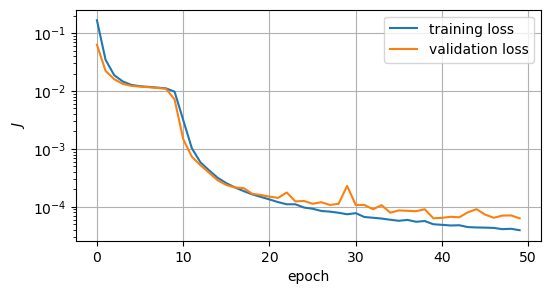

In [23]:
# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.semilogy(train_log.epoch, train_log.history["loss"], label="training loss")
ax.semilogy(train_log.epoch, train_log.history["val_loss"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

I am going to do a chained prediction. The way this is going to work is that I choose some time and initialise with the first 10 sequences (because I took `seq_length=10` above). The model is going to predict 10 frames, but I am going to keep the last one: for example, for $t=0, \ldots 9$ the model would predict $t=1, \ldots 10$, and I am going to discard all except the last one. I am then going to piggyback on that new prediction to predict subsequent frames.

Further more I am going to squeeze out the dummy `channel` dimensions that I don't need.

In [24]:
# chained prediction

t_ind_init = 201
Y_true = sol[t_ind_init::, :]  # from some index to the end

# initialise array of zeros to dump outputs in
Y_pred = np.zeros(Y_true.shape)
Y_pred[:seq_length, :] = Y_true[:seq_length, :]

# make predictions: add in dummy dims for model, then squeeze out dummy dims
# (probably not memory efficient here)
for i in range(Y_pred.shape[0] - seq_length):
    if i % 30 == 0:
        print(f"working at {i} / {Y_pred.shape[0] - seq_length}...")
    new_seq = simple_ConvLSTM.predict(
        Y_pred[np.newaxis, i:seq_length+i, :, np.newaxis], 
        verbose=0)
    Y_pred[seq_length+i, :] = new_seq[0, -1, :, 0]

working at 0 / 290...
working at 30 / 290...
working at 60 / 290...
working at 90 / 290...
working at 120 / 290...
working at 150 / 290...
working at 180 / 290...
working at 210 / 290...
working at 240 / 290...
working at 270 / 290...


Only going to plot the resulting Hovmöller diagram.

Text(0.5, 1.0, 'Model truth')

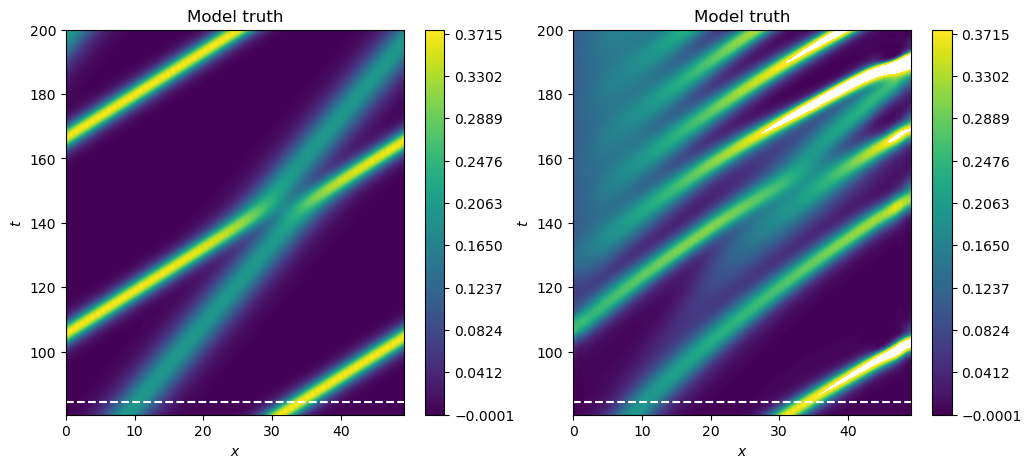

In [25]:
# Hovmoller plot (time going up)

cmin, cmax = Y_true.min(), Y_true.max()

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
cs = ax.contourf(x, t[t_ind_init::], Y_true, levels=np.linspace(cmin, cmax, 101))
ax.plot([x[0], x[-1]], [t[t_ind_init+seq_length], t[t_ind_init+seq_length]], 'w--')
cax = plt.colorbar(cs)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
ax.set_title(r'Model truth')

ax = plt.subplot(1, 2, 2)
cs = ax.contourf(x, t[t_ind_init::], Y_pred, levels=np.linspace(cmin, cmax, 101))
ax.plot([x[0], x[-1]], [t[t_ind_init+seq_length], t[t_ind_init+seq_length]], 'w--')
cax = plt.colorbar(cs)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
ax.set_title(r'Model truth')

In the above what we see is that the predictions are ok for a bit, but then it starts losing integrity. Some aspects such as the interaction of the waves is sort of kept (at around $t=150$). There is arguably some limited skill that could probably be improved quite a bit with model tuning etc.

> <span style="color:red">Q.</span> Try plotting the individual outputs of the time frames to see how the predictions change in time compared to the target data (i.e. do line plots rather than do Hovmoller diagrams).
>
> <span style="color:red">Q.</span> Can try and be quantitative and compute the mismatch over time of the predictions (e.g. the $L^2$ error as a function of time say). 
>
> <span style="color:red">Q.</span> Because of how I set up the above ConvLSTM architecture, in the above I predict whole sequences even though I only use the end one. Try modifying it so that it doesn't need to do that. One way would be to add a linear layer instead (or in addition) of the `Conv3D` layer above to squash the `seq_length` dimension down to `1`. I assume there are other ways to do it also.
>
> (For things larger than one space dimension, e.g. an image, you would need to flatten, do linear layer and the reshape the output instead).
>
> <span style="color:red">Q.</span> Experiment with model architecture and hyper-parameters etc.
>
> The probably interesting one here is `seq_length` and `batch_size`: I find increasing `batch_size` tends to degrade the model particularly when `seq_length` is larger, which is unfortunate because larger `seq_length` and smaller `batch_size` increases the training time...

----------------
# More involved exercises with this notebook

## 1) The Lorenz (1963) model

The code for generating the data for the famous butterfly diagram from the [Lorenz (1963) model](https://en.wikipedia.org/wiki/Lorenz_system) is given below. Have a look at deploying RNNs for that; you will need to modify the sizes here because the Lorenz63 model state is described by three variables. 

This is an example where we have [chaos](https://en.wikipedia.org/wiki/Chaos_theory) in the sense of sensitive dependence on initial conditions, and the predictive step is particularly hard. 

The question might not be whether we have skill in predicting the state $(x,y,z)$, but whether the resulting model at least respects the statistics, i.e. whether the predictions swirl round the two wings. Compare this to predicting the weather and the climate respectively.

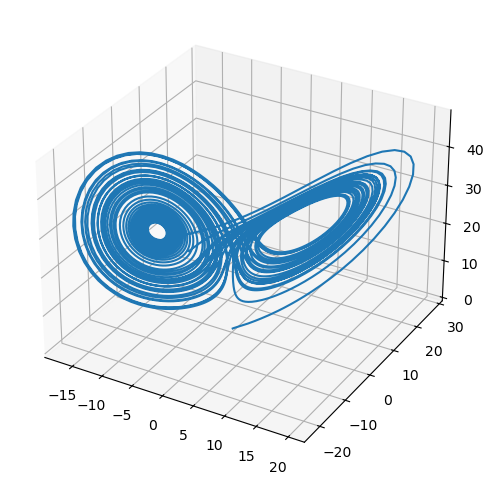

In [26]:
from mpl_toolkits.mplot3d import Axes3D

def lorenz63(t, state, sigma, rho, beta):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

state0 = [1.0, 1.0, 1.0]  # Initial state
params = (10.0, 28.0, 8.0/3.0)  # sigma, rho, beta

t = np.linspace(0, 50, 5000)
sol = solve_ivp(lorenz63, [t[0], t[-1]], [0.1, 0.1, 0.1], t_eval=t, args=params)

x, y, z = sol.y

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")
ax.plot(x, y, z)

## 2) Time-series forecasting

Try and adapt this [atmospheric example](https://keras.io/examples/timeseries/timeseries_weather_forecasting/) that makes use of observational data yourself. The example page provides the data and so forth.

If you can do that you could try doing something similar for the provided bacteria data if you like; ssee the assignments folder for the data file. The data does have a time element to it (every two weeks?), although in the assignment I suggest for you to group it in terms of seasons.

## 3) ConvLSTM for Kuramoto-Sivashinsky

As above for ConvLSTM but do this for the [Kuramoto-Sivashinsky](https://en.wikipedia.org/wiki/Kuramoto%E2%80%93Sivashinsky_equation) equaton, which has some nominal application in ocaenography. This is a chaotic system for large enough domain sizes.

Text(0, 0.5, '$t$')

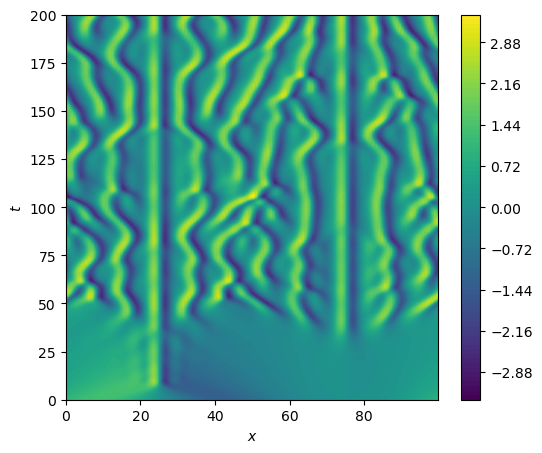

In [27]:
# 3) Kuramoto-Sivashinsky equation
#    model variable here is u(x,t), you can think of it as amplitude of something
#    would suggest trying to vary L, in particular decreasing it here

# define the subroutine for generating \partial u / \partial t
def ks(u, t, L):
    ux = psdiff(u, period=L)
    uxx = psdiff(u, period=L, order=2)
    uxxxx = psdiff(u, period=L, order=4)
    return -uxx - uxxxx - u*ux

# set the space and time grid
L = 32*np.pi
N = 128
dx = L / (N - 1.0)
x = np.linspace(0, (1-1.0/N)*L, N)

# Set the time sample grid.
T = 200
t = np.linspace(0, T, 501)

# initial conditions (selection of cosines and sines will do)
u0 = np.cos(x/16)*(1+np.sin(x/16))
sol = odeint(ks, u0, t, args=(L,), mxstep=5000)

# Hovmoller plot (time going up; have a think about what this is showing)
fig = plt.figure(figsize=(6, 5))
ax = plt.axes()
cs = ax.contourf(x, t, sol, levels=101)
cax = plt.colorbar(cs)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')

## 4) Text prediction

Have a look at this Keras example for [text prediction](https://keras.io/examples/generative/lstm_character_level_text_generation/) to see how you manipulate text data, pass these around as data for RNN layers, and train up a text predictor.

Once you are comfortable with what is going on, try and find do it on your own dataset (find a digitised novel or something; a previous student of mine used [The Communist Manifesto](https://en.wikipedia.org/wiki/The_Communist_Manifesto) for a project computing information entropy, so you could try using that.